In [1]:
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
fs = 44100
f1 = 200
f2 = 600
dur = 3*60
n = np.arange(dur*fs)
nfft = 2048
alpha = 0.6
width = 0.5

s = np.sin(2*np.pi*f1/fs * n) + np.sin(2*np.pi*f2/fs * n)

In [3]:
from scipy.signal import stft
f, t, Zxx = stft(x=s, fs=fs, nperseg=nfft, return_onesided=True)

In [4]:
Zxx.shape

(1025, 7753)

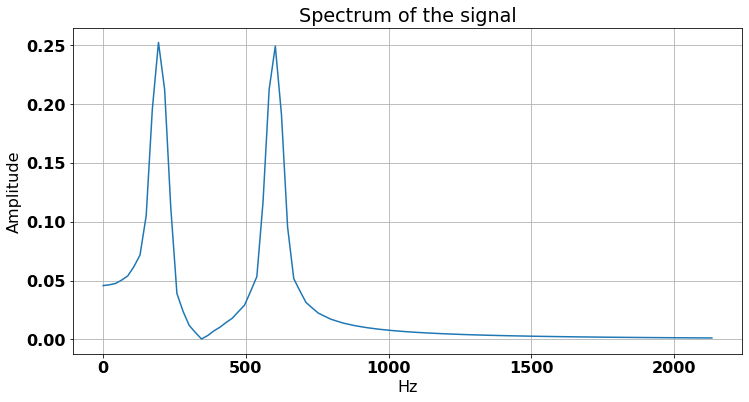

In [23]:
# 1) Spectrum of the signal

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()
ax.plot(f[:100], np.abs(Zxx[:100, 0]))
plt.grid()
plt.title('Spectrum of the signal')
plt.ylabel('Amplitude')
plt.xlabel('Hz')
plt.show()

In [10]:
def hz2brk(hz):
    return 6 * np.arcsinh(hz/600)

def map2brk_mat(fs):
    #Constructing matrix W which has 1’s for each Bark subband, and 0’s else
    #max_brk = np.round(hz2brk(fs/2)).astype(np.int64)
    max_brk = hz2brk(fs/2)
    #max_brk = np.round(b).astype(np.int64)
    nfilts = np.round(max_brk/width).astype(np.int64)
    step_barks = max_brk/(nfilts-1)
    
    binbarks = hz2brk(np.linspace(0,(nfft//2),(nfft//2)+1)*fs//nfft)
    W = np.zeros((nfilts, nfft))
    for i in range(nfilts):
        W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
    return W, nfilts, max_brk

def map2brk(x, W):
    nfreqs = int(nfft/2)
    mXbark = (np.dot(np.abs(x[:nfreqs]).T**2.0, W[:, :nfreqs].T))**(0.5)
    return mXbark

def SF_mat(max_brk, nfilts):
    #alpha = 0.6
    #nfilts = shapes[0]
    #max_brk = shapes[1]
    #max_brk = np.round(hz2brk(fs/2)).astype(np.int64)
    fadB = 14.5 + 12 # Simultaneous masking for tones at Bark band 12
    fbdb = 7.5 # Upper slope of spreading function
    fbbdb = 26.0 # Lower slope of spreading function
    #maxbark = hz2bark(maxfreq)
    #max_brk = np.round(hz2brk(fs/2)).astype(np.int64)
    sf_brk_dB = np.zeros(2*nfilts)
    #upper slope, fbdB attenuation per Bark, over maxbark Bark (full frequency range),
    #with fadB dB simultaneous masking:
    sf_brk_dB[0:nfilts] = np.linspace(-max_brk*fbdb, -2.5, nfilts) - fadB
    #lower slope fbbdb attenuation per Bark, over maxbark Bark (full frequency range):
    sf_brk_dB[nfilts:2*nfilts] = np.linspace(0, -max_brk*fbbdb, nfilts) - fadB
    #Convert from dB to "voltage" and include alpha exponent
    sf_brk = 10**(sf_brk_dB*alpha / 20)
    #Spreading functions for all bark scale bands in a matrix:
    sf_mat = np.zeros((nfilts, nfilts))
    for k in range(nfilts):
        sf_mat[:,k] = sf_brk[(nfilts - k):(2*nfilts - k)]
    return sf_mat

def SF(max_brk, nfilts):
    #nfilts = shapes[0]
    #max_brk = shapes[1]
    #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    #computes the spreading function protoype, in the Bark scale.
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64   
    
    #Number of our Bark scale bands over this range: nfilts=64
    sf_db = np.zeros(2*nfilts)
   
    #Spreading function prototype, "nfilts" bands for lower slope 
    sf_db[0:nfilts] = np.linspace(-max_brk*27,-8,nfilts)-23.5
   
    #"nfilts" bands for upper slope:
    sf_db[nfilts:2*nfilts] = np.linspace(0,-max_brk*12.0,nfilts)-23.5
    return sf_db

def MT(x,sf_mat):
    #mt = x**alpha @ sf_mat
    mt = np.dot(x**alpha, sf_mat)
    #apply the inverse exponent to the result:

    return mt**(1.0/alpha)

def brk2hz(bark):
    return 600 * np.sinh(bark/6)

def MT_bark(x,sf_mat, max_brk):
    mt = np.dot(x**alpha, sf_mat**alpha)
  
    #apply the inverse exponent to the result:
    return mt**(1.0/alpha)

def MTQ_bark(x,sf_mat, max_brk): 
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6), 
    #fs: sampling freq., nfilts: number of Bark subbands
    #nfilts: Number of subbands in the Bark domain, for instance 64  
    #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
    #Compute the non-linear superposition:
    mt = np.dot(x**alpha, sf_mat**alpha)
  
    #apply the inverse exponent to the result:
    mt = mt**(1.0/alpha)
  
    #Threshold in quiet:
    #maxfreq = fs/2.0
    #maxbark=hz2bark(maxfreq)
    step_bark = max_brk/(nfilts-1)
    barks = np.arange(0,nfilts)*step_bark
  
    #convert the bark subband frequencies to Hz:
    f = brk2hz(barks) + 1e-6
    #Threshold of quiet in the Bark subbands in dB:
    LTQ = np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
    #Maximum of spreading functions and hearing threshold in quiet:
    mt1 = np.max((mt, 10.0**((LTQ-60)/20)),0)
    return mt1

def map2hz_mat(W):
    nfreqs = int(nfft/2)
    W_inv = np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

def map2hz(mt_bark, W_inv):
    nfreqs = int(nfft/2)
    #mt = np.dot(mt_bark, W_inv[:, :nfreqs].T)
    mt = W_inv @ mt_bark
    return mt

In [11]:
W, nfilts, max_brk = map2brk_mat(fs)
Zxx_brk = map2brk(Zxx, W)
Zxx_brk.shape, hz2brk(fs/2)

((7753, 52), 25.784822777395576)

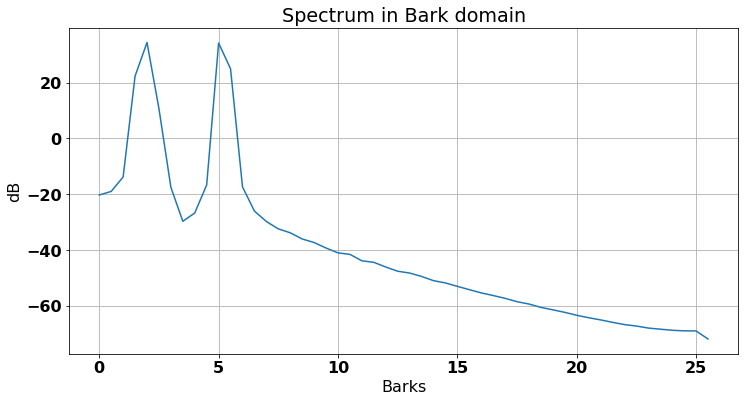

In [13]:
# 2) Magnitude Spectrum mapped to 1/2 Bark Bands

a = (np.abs(Zxx_brk)**2).sum(axis=0)
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()
ax.plot(width*np.arange(len(a)), 10*np.log10(a))
plt.grid()
plt.title("Spectrum in Bark domain")
plt.ylabel('dB')
plt.xlabel('Barks')
plt.show()

In [14]:
x = Zxx_brk[0, :]
sf_mat = SF_mat(max_brk, nfilts)
#sf = SF_mat(max_brk, nfilts)
mt_bark = MT_bark(x, sf_mat, max_brk)
mt_bark2 = MTQ_bark(x, sf_mat, max_brk)
#sf_mat = SF_mat(max_brk, nfilts)
#mt = MT_bark(x, sf_mat, max_brk)
#mt.shape

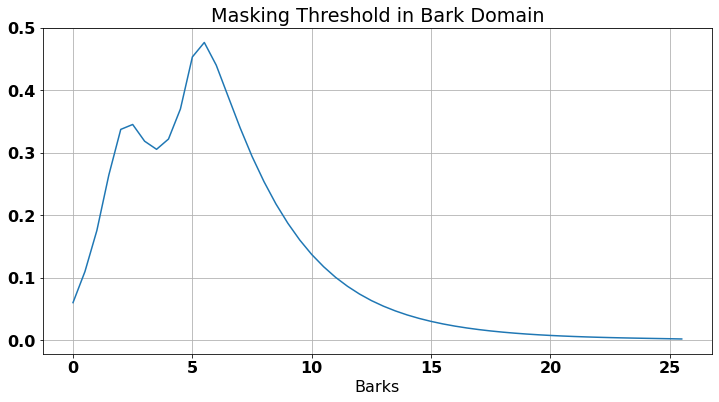

In [16]:
# 3) Masking Threshold in Bark Domain (todo + signal)

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()
ax.plot(width*np.arange(len(mt_bark)), mt_bark)
plt.grid()
plt.title("Masking Threshold in Bark Domain")
plt.xlabel('Barks')
plt.show()

In [17]:
W_inv = map2hz_mat(W)
mt = map2hz(mt_bark, W_inv)

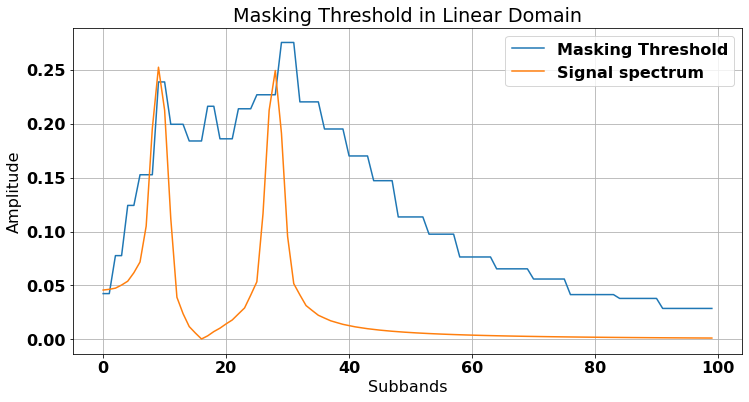

In [20]:
# 4) Masking Threshold back in Linear Domain

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()
ax.plot(mt[:100])
ax.plot(np.abs(Zxx[:100, 0]))
plt.title('Masking Threshold in Linear Domain')
plt.ylabel('Amplitude')
plt.xlabel('Subbands')
plt.grid()
ax.legend(['Masking Threshold', 'Signal spectrum'])
plt.show()

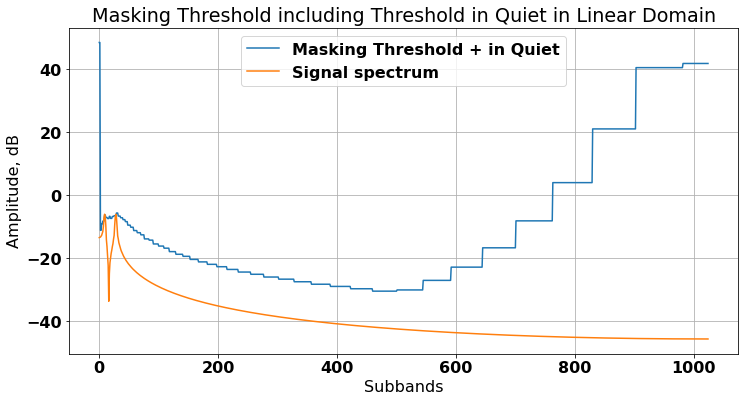

In [22]:
# 5) Masking Threshold including Threshold in Quiet for our signal

mt2 = map2hz(mt_bark2, W_inv)
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot()
ax.plot(10*np.log10(mt2))
ax.plot(10*np.log10(np.abs(Zxx[:, 0])))
plt.grid()
plt.title('Masking Threshold including Threshold in Quiet in Linear Domain')
plt.ylabel('Amplitude, dB')
plt.xlabel('Subbands')
plt.legend(['Masking Threshold + in Quiet', 'Signal spectrum'])
plt.show()

/home/ainur/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


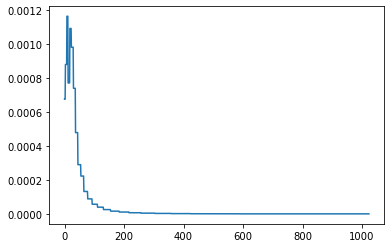

In [103]:
#W_inv = map2hz_mat(W, 2*nfft)
#mt = map2hz(mt_bark, W_inv, nfft)
#nfreqs = int(nfft/2)
#W_inv = np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfft + 1]).T
#plt.plot(W_inv[:, 30])
#np.sum(W,1).shape
#np.diag((1.0/np.sum(W,1))**0.5)
#W_inv[:5, :5], W[:10, :10], W.shape

W_inv = np.linalg.pinv(W)
mt = map2hz(mt_bark, W_inv, 2*nfft)
plt.plot(mt)

/home/ainur/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


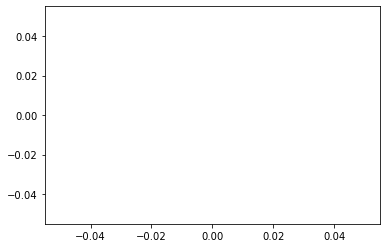

In [45]:
plt.plot(mt)



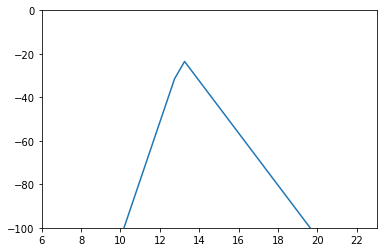

In [89]:
#sf.shape
bark=np.linspace(0,max_brk,nfilts)
plt.plot(bark, sf[26:(26+nfilts)])
plt.axis([6, 23,-100,0])
plt.show()

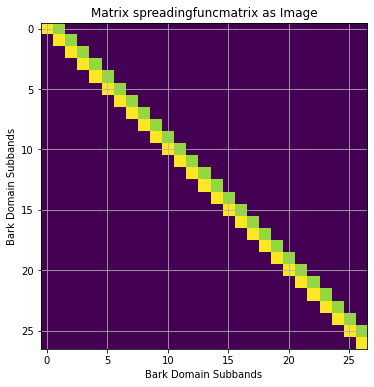

In [41]:
plt.figure(figsize=(10,6))
plt.imshow(sf_mat)
plt.title('Matrix spreadingfuncmatrix as Image')
plt.xlabel('Bark Domain Subbands')
plt.ylabel('Bark Domain Subbands')
plt.grid()

In [95]:
def hz2brk(hz):
    return 6 * np.arcsinh(hz/600)

def map2brk_mat(fs, nfft):  #  -> (27, 1024)
    #Constructing matrix W which has 1’s for each Bark subband, and 0’s else
    #max_brk = np.round(hz2brk(fs/2)).astype(np.int64)
    b = hz2brk(fs/2)
    max_brk = np.round(b).astype(np.int64)
    nfilts = np.round(b/width).astype(np.int64)
    #W = np.zeros((nfilts, nfft))
    #freq = np.linspace(0, fs//2, nfft)
    
    binbarks = hz2bark(np.linspace(0,(nfft//2),(nfft//2)+1)*fs//nfft)
    W = np.zeros((nfilts, nfft))
    for i in range(nfilts):
        W[i,0:(nfft//2)+1] = (np.round(binbarks/step_barks)== i)
    return W

    for i in range(nfilts):
        W[i, :] = (np.round(hz2brk(freq)) == i)
    return W, nfilts, max_brk

def map2brk(x, W):
    return W @ x

def SF_mat(max_brk, nfilts):
    #alpha = 0.6
    #nfilts = shapes[0]
    #max_brk = shapes[1]
    #max_brk = np.round(hz2brk(fs/2)).astype(np.int64)
    fadB = 14.5 + 12 # Simultaneous masking for tones at Bark band 12
    fbdb = 7.5 # Upper slope of spreading function
    fbbdb = 26.0 # Lower slope of spreading function
    #maxbark = hz2bark(maxfreq)
    #max_brk = np.round(hz2brk(fs/2)).astype(np.int64)
    sf_brk_dB = np.zeros(2*nfilts)
    #upper slope, fbdB attenuation per Bark, over maxbark Bark (full frequency range),
    #with fadB dB simultaneous masking:
    sf_brk_dB[0:nfilts] = np.linspace(-max_brk*fbdb, -2.5, nfilts) - fadB
    #lower slope fbbdb attenuation per Bark, over maxbark Bark (full frequency range):
    sf_brk_dB[nfilts:2*nfilts] = np.linspace(0, -max_brk*fbbdb, nfilts) - fadB
    #Convert from dB to "voltage" and include alpha exponent
    sf_brk = 10**(sf_brk_dB*alpha / 20)
    #Spreading functions for all bark scale bands in a matrix:
    sf_mat = np.zeros((nfilts, nfilts))
    for k in range(nfilts):
        sf_mat[:,k] = sf_brk[(nfilts - k):(2*nfilts - k)]
    return sf_mat

def SF(max_brk, nfilts):
    #nfilts = shapes[0]
    #max_brk = shapes[1]
    #usage: spreadingfunctionmatdB=f_SP_dB(maxfreq,nfilts)
    #computes the spreading function protoype, in the Bark scale.
    #Arguments: maxfreq: half the sampling freqency
    #nfilts: Number of subbands in the Bark domain, for instance 64   
    
    #Number of our Bark scale bands over this range: nfilts=64
    sf_db = np.zeros(2*nfilts)
   
    #Spreading function prototype, "nfilts" bands for lower slope 
    sf_db[0:nfilts] = np.linspace(-max_brk*27,-8,nfilts)-23.5
   
    #"nfilts" bands for upper slope:
    sf_db[nfilts:2*nfilts] = np.linspace(0,-max_brk*12.0,nfilts)-23.5
    return sf_db

def MT(x,sf_mat):
    #mt = x**alpha @ sf_mat
    mt = np.dot(x**alpha, sf_mat)
    #apply the inverse exponent to the result:

    return mt**(1.0/alpha)

def brk2hz(bark):
    return 600 * np.sinh(bark/6)

def MT_bark(x,sf_mat, max_brk):
    mt = np.dot(x**alpha, sf_mat**alpha)
  
    #apply the inverse exponent to the result:
    return mt**(1.0/alpha)

def MTQ_bark(x,sf_mat, max_brk): 
    #Computes the masking threshold on the Bark scale with non-linear superposition
    #usage: mTbark=maskingThresholdBark(mXbark,spreadingfuncmatrix,alpha)
    #Arg: mXbark: magnitude of FFT spectrum, on the Bark scale
    #spreadingfuncmatrix: spreading function matrix from function spreadingfunctionmat
    #alpha: exponent for non-linear superposition (eg. 0.6), 
    #fs: sampling freq., nfilts: number of Bark subbands
    #nfilts: Number of subbands in the Bark domain, for instance 64  
    #Returns: mTbark: the resulting Masking Threshold on the Bark scale 
  
    #Compute the non-linear superposition:
    mt = np.dot(x**alpha, sf_mat**alpha)
  
    #apply the inverse exponent to the result:
    mt = mt**(1.0/alpha)
  
    #Threshold in quiet:
    #maxfreq = fs/2.0
    #maxbark=hz2bark(maxfreq)
    step_bark = max_brk/(nfilts-1)
    barks = np.arange(0,nfilts)*step_bark
  
    #convert the bark subband frequencies to Hz:
    f = brk2hz(barks) + 1e-6
    #Threshold of quiet in the Bark subbands in dB:
    LTQ = np.clip((3.64*(f/1000.)**-0.8 -6.5*np.exp(-0.6*(f/1000.-3.3)**2.)+1e-3*((f/1000.)**4.)),-20,160)
    #Maximum of spreading functions and hearing threshold in quiet:
    mt1 = np.max((mt, 10.0**((LTQ-60)/20)),0)
    return mt1

def map2hz_mat(W, nfft):
    nfreqs = int(nfft/2)
    W_inv = np.dot(np.diag((1.0/np.sum(W,1))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

def map2hz(mt_bark, W_inv, nfft):
    nfreqs = int(nfft/2)
    #mt = np.dot(mt_bark, W_inv[:, :nfreqs].T)
    mt = W_inv @ mt_bark
    return mt

In [69]:
W.shape

(27, 1024)

In [150]:
for i in range(52):
    print(W[i].sum())

3.0
5.0
4.0
6.0
5.0
7.0
7.0
8.0
10.0
10.0
13.0
15.0
18.0
20.0
24.0
29.0
33.0
40.0
47.0
55.0
65.0
77.0
91.0
107.0
127.0
150.0
48.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


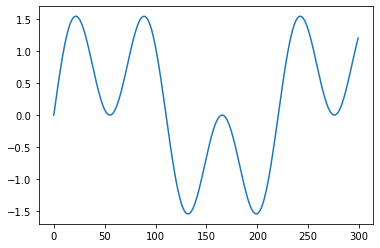

In [8]:
plt.plot(s[:300])